# 随机森林
Bagging模型
多个决策树，数据随机采样，特征随机选择。



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

| 特征 | 含义 |
| ---- | ---- |
| Pclass | 船舱等级|
| SibSp | 同行的兄弟姐妹或朋友的数量 |
| Parch | 同行的父母或子女的数量 |
| Ticket | 船票编号|
| Fare | 票价 |
| Cabin | 船舱号码 |
| Embarked | 登船港口 |

In [3]:
data = pd.read_csv("titanic_train.csv")
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 缺失值填充
可以看到，年龄属性存在缺失值，所以需要对其进行填充。



In [4]:
# 数值数据类型，均值填充
data["Age"] = data["Age"].fillna(data["Age"].median())
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 字符类型映射
对于性别类型，我们可以使用0，1来代表男和女

In [5]:
# 手动映射
# 查看数据类型
data["Sex"].unique()

# 字符映射
data.loc[data["Sex"] == "male","Sex"] = 0
data.loc[data["Sex"] == "female","Sex"] = 1

data["Sex"].unique()

array([0, 1], dtype=object)

In [6]:
# label encoder 自动映射
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# 正向映射
data["Embarked"] = le.fit_transform(data["Embarked"])

In [7]:
# 查看映射类型
le.classes_

# 数据反向映射
le.inverse_transform(data["Embarked"])

array(['S', 'C', 'S', 'S', 'S', 'Q', 'S', 'S', 'S', 'C', 'S', 'S', 'S',
       'S', 'S', 'S', 'Q', 'S', 'S', 'C', 'S', 'S', 'Q', 'S', 'S', 'S',
       'C', 'S', 'Q', 'S', 'C', 'C', 'Q', 'S', 'C', 'S', 'C', 'S', 'S',
       'C', 'S', 'S', 'C', 'C', 'Q', 'S', 'Q', 'Q', 'C', 'S', 'S', 'S',
       'C', 'S', 'C', 'S', 'S', 'C', 'S', 'S', 'C', nan, 'S', 'S', 'C',
       'C', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'Q', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'C', 'C', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'Q', 'S', 'C', 'S', 'S', 'C', 'S', 'Q',
       'S', 'C', 'S', 'S', 'S', 'C', 'S', 'S', 'C', 'Q', 'S', 'C', 'S',
       'C', 'S', 'S', 'S', 'S', 'C', 'S', 'S', 'S', 'C', 'C', 'S', 'S',
       'Q', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'C',
       'Q', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'Q', 'S', 'S', 'C', 'S', 'S', 'C', 'S', 'S', 'S

# 训练过程

In [13]:
# 线性回归
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# 只用部分属性进行训练
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

alg = LinearRegression()

kf = KFold(5)

predictions = []

for train, test in kf.split(data):
    X_train = data[predictors].iloc[train, :]
    y_train = data["Survived"].iloc[train]
    X_test = data[predictors].iloc[test, :]
    y_test = data["Survived"].iloc[test]
    alg.fit(X_train, y_train)
    score = alg.score(X_test, y_test)
    predictions.append(score)
predictions

[0.3363327242550761,
 0.3714704414134996,
 0.3822236612607133,
 0.3173246128014118,
 0.45223359680063424]

In [21]:
# 逻辑回归
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
alg = LogisticRegression(max_iter = 1000)
scores = cross_validate(alg, data[predictors], data["Survived"], cv=3)
scores 

{'fit_time': array([0.01200175, 0.01159215, 0.01306081]),
 'score_time': array([0.00100398, 0.00100017, 0.00100064]),
 'test_score': array([0.79124579, 0.77441077, 0.79461279])}

In [22]:
# 加载测试数据
test = pd.read_csv("test.csv")
test["Age"] = test["Age"].fillna(test["Age"].median())
test["Fare"] = test["Fare"].fillna(test["Fare"].median())
test.loc[test["Sex"] == "male", "Sex"] = 0 
test.loc[test["Sex"] == "female", "Sex"] = 1
test["Embarked"] = test["Embarked"].fillna("S")
test["Embarked"] = le.fit_transform(test["Embarked"])

alg.fit(data[predictors], data["Survived"])
alg.predict(test[predictors])

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [25]:
# 随机森林
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_val_score(alg, data[predictors], data["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
scores

array([0.78114478, 0.80808081, 0.8013468 ])

In [45]:
# 随机森林调参
alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4)
scores = cross_val_score(alg, data[predictors], data["Survived"], cv=3)

scores

array([0.8047138 , 0.83838384, 0.83164983])

# 特征工程
方法一：制作新特征

In [36]:
# 合并家庭成员
data["FamilySize"] = data["SibSp"] + data["Parch"]

# 名字长度
data["NameLength"] = data["Name"].apply(lambda x: len(x))

In [37]:
import re

# 获取称谓缩写，形如：Xx.
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search[1]
    return ""

In [42]:
# 获取称谓
titles = data["Name"].apply(get_title)
print(pd.value_counts(titles))
# 字符映射
title_encoder = LabelEncoder()
titles = title_encoder.fit_transform(titles)
print(pd.value_counts(titles))
data["Title"] = titles


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Don           1
Mme           1
Jonkheer      1
Lady          1
Ms            1
Countess      1
Capt          1
Sir           1
Name: Name, dtype: int64
12    517
9     182
13    125
8      40
4       7
15      6
1       2
10      2
7       2
2       1
3       1
16      1
5       1
6       1
11      1
14      1
0       1
dtype: int64


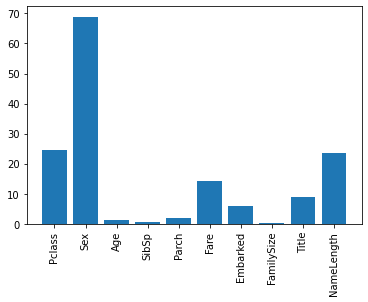

In [43]:
# 方差分析选取最佳特征
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "NameLength"]

# f_classif : ANOVA-方差分析
selector = SelectKBest(f_classif, k=5)
selector.fit(data[predictors], data["Survived"])

# p值转换为得分（负对数转换，p值越小得分越高）
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [62]:

# 选择得分最高的五个属性
predictors = ["Pclass", "Sex", "Fare", "Title", "NameLength"]

alg = RandomForestClassifier( n_estimators=50, min_samples_split=8, min_samples_leaf=4)
scores = cross_val_score(alg, data[predictors], data["Survived"], cv=5)

scores


array([0.83240223, 0.80337079, 0.83707865, 0.79775281, 0.83146067])

In [63]:
# 不正确
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# 使用组合算法
# 提升树 + 逻辑回归
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title",]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(3)

predictions = []
for train, test in kf.split(data):
    train_target = data["Survived"].iloc[train]
    full_test_predictions = []
    # 对于两种算法分别作训练与预测
    for alg, predictors in algorithms:
        alg.fit(data[predictors].iloc[train,:], train_target)
        test_predictions = alg.predict_proba(data[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    
    # 使用两种算法输出的均值作为我们组合算法的输出
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # 由概率计算种类
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# 计算准确率
accuracy = sum(predictions[predictions == data["Survived"]]) / len(predictions)
print(accuracy)


0.265993265993266


c:\Users\wang\miniconda3\envs\python364\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\wang\miniconda3\envs\python364\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/